In [42]:
import collections
import os
import math
from math import radians
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import haversine_distances

os.makedirs('metadata', exist_ok=True)

# Taipei MRT Daily Traffic
- **Input file**: metadata/mrt_ubike_shortest_dist.csv
- **Output file**: metadata/april_mrt_traffic.csv

In [2]:
filename = '臺北捷運每日分時各站OD流量統計資料_2024'
df_april = pd.read_csv(filename + '04.csv')
# df_march = pd.read_csv(filename + '03.csv')

In [7]:
df_april_population = df_april[['日期', '時段', '出站', '人次']].groupby(by=['日期', '時段', '出站']).sum().reset_index()
# df_march_population = df_march[['日期', '時段', '出站', '人次']].groupby(by=['日期', '時段', '出站']).sum().reset_index()

### Filter April population by ubike sites in 大安 & 台大公館校區

In [123]:
df_ubike = pd.read_csv('metadata/mrt_ubike_shortest_dist.csv')
df_ubike

,sna,sno,mrt_name,mrt_distances,mrt_shortname
0,YouBike2.0_捷運古亭站(6號出口),500101110.0,古亭站出口6,14.588981,古亭
1,YouBike2.0_捷運古亭站(5號出口),500101111.0,古亭站出口5,6.639189,古亭
2,YouBike2.0_捷運古亭站(3號出口),500101232.0,古亭站出口3,17.084130,古亭
3,YouBike2.0_金杭公園,500101119.0,東門站出口2,360.814689,東門
4,YouBike2.0_金甌女中,500101118.0,東門站出口2,345.447333,東門
...,...,...,...,...,...
228,YouBike2.0_臺大鄭江樓北側,500119084.0,科技大樓站出口,421.224983,科技大樓
229,YouBike2.0_臺大黑森林西側,500119088.0,科技大樓站出口,361.366110,科技大樓
230,YouBike2.0_臺大明達館機車停車場,500119064.0,科技大樓站出口,502.548544,科技大樓
231,YouBike2.0_臺大明達館北側(員工宿舍),500119091.0,科技大樓站出口,479.570280,科技大樓


In [126]:
# Get the short name of mrt name
mrt_names = df_ubike['mrt_name'].unique()
short_name_dict = dict()
for mrt_name in mrt_names:
    short_name = mrt_name.split('站')[0]
    short_name_dict[mrt_name] = short_name
df_ubike['mrt_shortname'] = df_ubike['mrt_name'].apply(lambda x: short_name_dict[x])

### Filter and write April traffic by `mrt_shortname`

In [119]:
mrt_set = df_mrt_merged['mrt_shortname'].unique()
df_april_population = df_april_population.rename(columns={
    "出站": "mrt_shortname",
    "人次": "person_time",
    "時段": "hour",
    "日期": "date"
})
# uncomment if necessary
# df_april_population[df_april_population['mrt_shortname'].isin(mrt_set)].to_csv('metadata/april_mrt_traffic.csv', index=False)

# Shortest distance from the YouBike station to the closest MRT station
- **Input file**: ubike processed data from 大安 and 台大公館校區
  (e.g., `merged_20240506000130_20240512235822_2mins.csv`)
- **Output file**: metadata/mrt_ubike_shortest_dist.csv

## Read Processed YouBike Data 

In [133]:
%%time
df_list = []
for filename in ['merged_20240506000130_20240512235822_2mins.csv', 'merged_20240506000130_20240512235822_臺大公館校區_2mins.csv']:
    df = pd.read_csv(filename)
    df = df.drop_duplicates(['latitude', 'longitude'], keep='last') # remove duplicated data
    df_list.append(df)

df_ubike = pd.concat(df_list) # 1,016,346 -> 233 without duplicates
df_ubike['srcUpdateTime'] = pd.to_datetime(df['srcUpdateTime'])

CPU times: user 2.62 s, sys: 180 ms, total: 2.8 s
Wall time: 2.8 s


## Read Taipei MRT data with Latitude and Longitude

In [21]:
# Read Taipei MRT data (including latitude and longitude)
df_mrt = pd.read_csv('metadata/taipei_mrt_info_utf8.csv')
df_mrt

,Unnamed: 0,項次,出入口名稱,出入口編號,經度,緯度,是否為無障礙用
0,324,325,迴龍站出口2,2,121.410770,25.021180,否
1,323,324,迴龍站出口1,1,121.411269,25.021821,是
2,325,326,迴龍站出口3,3,121.412564,25.022540,否
3,0,1,頂埔站出口1,1,121.418336,24.959327,是
4,1,2,頂埔站出口2,2,121.418357,24.958947,否
...,...,...,...,...,...,...,...
382,55,56,南港展覽館站出口2A,2A,121.617200,25.055336,是
383,57,58,南港展覽館站出口6,6,121.617928,25.054764,否
384,58,59,南港展覽館站出口7,7,121.618148,25.054035,否
385,53,54,南港展覽館站出口3,3,121.618239,25.055123,否


## Find shortest path from UBike site to MRT station

In [135]:
%%time

def earth_distance(lng1, lng2, lat1, lat2):
    radians1 = [radians(lng1), radians(lat1)]
    radians2 = [radians(lng2), radians(lat2)]
    res = haversine_distances([radians1, radians2])
    return res[0][1]* 6371000 # meter

ubike_data = collections.defaultdict(list)
for i, row in df_ubike.iterrows():
    shortest_dist = float('inf')
    closet_mrt = ""
    for i, rowm in df_mrt.iterrows():
        dist = earth_distance(rowm['經度'], row['longitude'], rowm['緯度'], row['latitude'])
        if dist < shortest_dist:
            shortest_dist = dist
            closet_mrt = rowm['出入口名稱']

    # Ubike data
    ubike_data['sna'].append(row['sna'])
    ubike_data['sno'].append(row['sno'])

    # Closest MRT
    ubike_data['mrt_name'].append(closet_mrt)
    ubike_data['mrt_distances'].append(shortest_dist)

CPU times: user 20.4 s, sys: 0 ns, total: 20.4 s
Wall time: 20.4 s


In [136]:
df_mrt_dist = pd.DataFrame(ubike_data)
# uncomment if necessary
# df_mrt_dist.to_csv('metadata/mrt_ubike_shortest_dist.csv', index=False) # write

,sna,sno,mrt_name,mrt_distances
0,YouBike2.0_仁愛復興路口,500101237.0,忠孝復興站出口2,184.594607
1,YouBike2.0_復興南路二段273號前,500101002.0,科技大樓站出口,30.222912
2,YouBike2.0_捷運信義安和站(1號出口),500101172.0,信義安和站出口1,6.609501
3,YouBike2.0_敦化南路二段103巷口,500101173.0,信義安和站出口2,444.436688
4,YouBike2.0_復興南路二段128巷口,500101174.0,科技大樓站出口,146.127437
...,...,...,...,...
228,YouBike2.0_臺大共同教室東南側,500119060.0,公館站出口2,353.314361
229,YouBike2.0_臺大黑森林西側,500119088.0,科技大樓站出口,361.366110
230,YouBike2.0_臺大公館停車場西北側,500119062.0,公館站出口2,369.811888
231,YouBike2.0_臺大水源舍區A棟,500119005.0,台電大樓站出口2,340.669767


## Convert MRT to UTF-8
- **Input**: TaipeiMRT.csv (downloaded from Taipei open data)
- **Output**: metadata/taipei_mrt_info_utf8.csv

In [ ]:
df_mrt = pd.read_csv('TaipeiMRT.csv', encoding='big5')
df_mrt = df_mrt.sort_values(by=['經度', '緯度'])
# uncomment if necessary
# df_mrt.to_csv('metadata/taipei_mrt_info_utf8.csv', index=False)

# Plot Data
RIP: for progress review

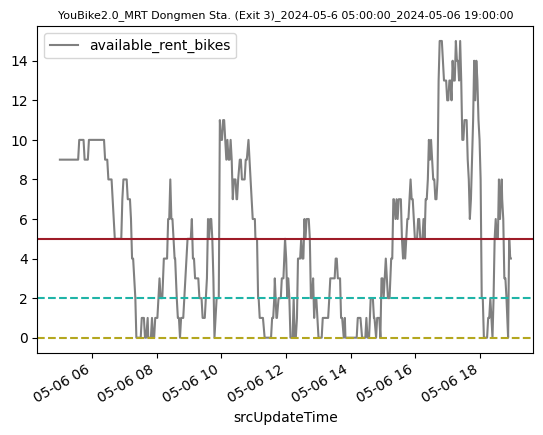

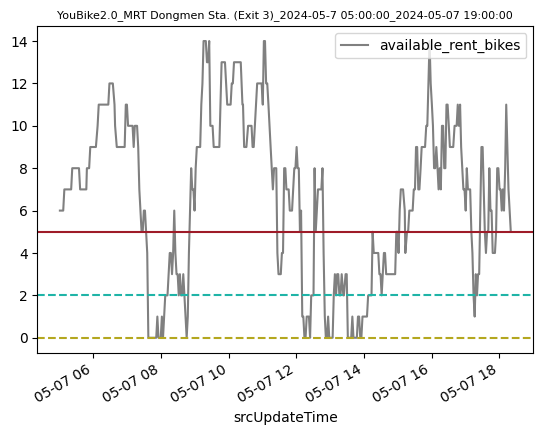

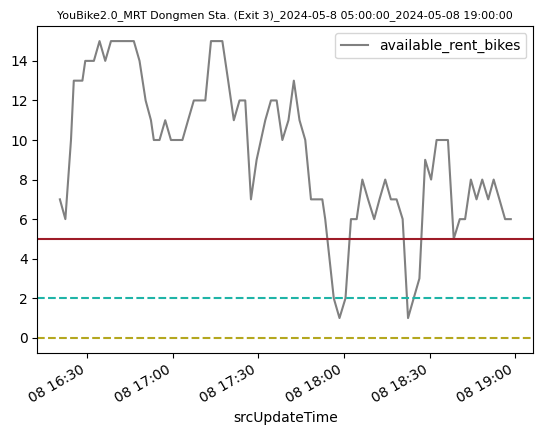

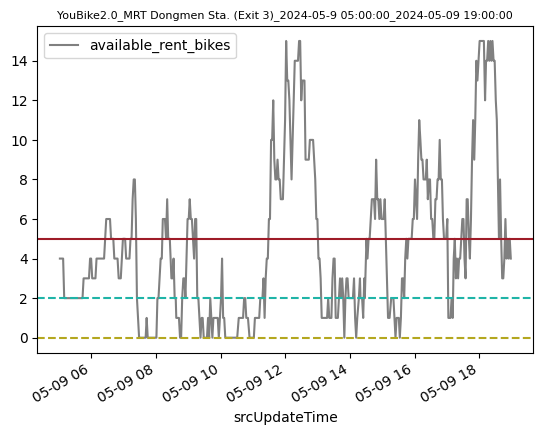

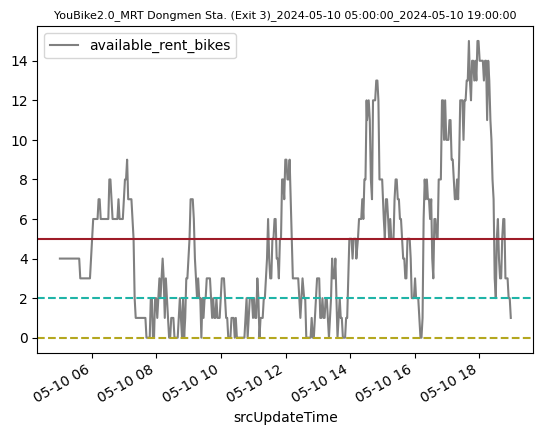

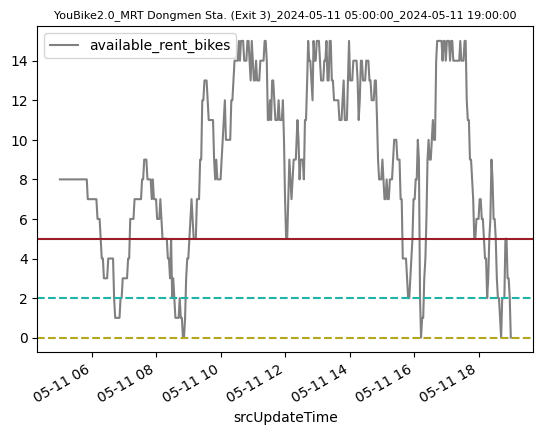

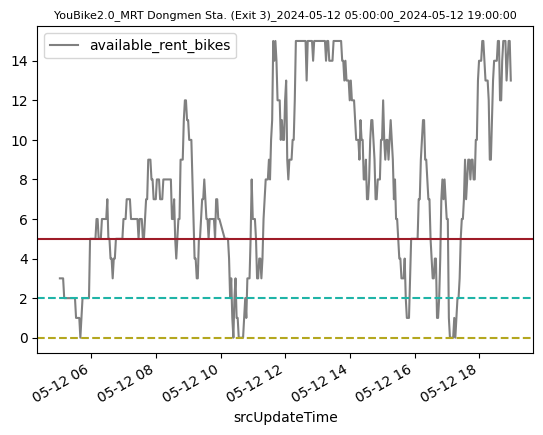

In [114]:
site = 'YouBike2.0_MRT Dongmen Sta. (Exit 3)' # 'YouBike2.0_捷運東門站(5號出口)'
# site = 'YouBike2.0_Aiguo & Jinshan Rd. Intersection'

for date in range(6,13):
    start_date = f'2024-05-{date} 05:00:00'
    end_date = pd.to_datetime(start_date) + pd.DateOffset(hour=19)
    # mask = (df['sna'] == 'YouBike2.0_捷運東門站(3號出口)') & (df['srcUpdateTime'] >= start_date) & (df['srcUpdateTime'] < end_date)
    mask = (df['snaen'] == site) & (df['srcUpdateTime'] >= start_date) & (df['srcUpdateTime'] < end_date)

    df[mask].plot(x='srcUpdateTime', y='available_rent_bikes', color='gray')
    plt.axhline(y=5, color='#9e1b28', linestyle='-')
    plt.axhline(y=2, color='#1fb4a7', linestyle='--')
    plt.axhline(y=0, color='#b4a71f', linestyle='--')
    plt.legend()

    # snaen
    title = f"{site}_{start_date}_{end_date}"
    plt.title(title, fontsize=8)
    plt.savefig(f"figs/{title}.png")